In [1]:
import os

import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')  # отключаю GPU, так как оно у меня слабое и не даёт преимущества

from utils import neural_network as nn
from utils import definitions as defs
from utils import visualization as viz

### ETL_step_nn

In [2]:
df = pd.read_excel(defs.ETLED_DATA_PATH_my_tree)

Удаляем вспомогательные вопросы.

In [3]:
df = df.drop(['pre4. Есть ответ на вопрос 4?'], axis=1)
df = df.drop(['pre11. Есть ответ на вопрос 11?'], axis=1)
df = df.drop(['pre20. Есть ответ на вопрос 20?'], axis=1)

Нормализуем численные признаки.

In [4]:
def standanrdize(df, feature_name):
    df[feature_name] = (df[feature_name] - df[feature_name].mean()) / df[feature_name].std()
    
def normalize(df, feature_name):
    df[feature_name] = (df[feature_name] - df[feature_name].min()) / (df[feature_name].max() - df[feature_name].min())
    
standanrdize(df, defs.QUESTION_2)
normalize(df, defs.QUESTION_4)
df[defs.QUESTION_4].fillna(0, inplace=True)
normalize(df, defs.QUESTION_22)
normalize(df, defs.QUESTION_24)
df[defs.QUESTION_24].fillna(0, inplace=True)

Кодируем категориальные признаки.

In [5]:
categorical_features = {
    defs.QUESTION_3: defs.ANSWERS_3,
    defs.QUESTION_5: defs.ANSWERS_5,
    defs.QUESTION_6: [defs.YES, defs.NO],
    defs.QUESTION_7: defs.ANSWERS_7,
    defs.QUESTION_8: [defs.YES, defs.NO],
    defs.QUESTION_9: defs.ANSWERS_9,
    defs.QUESTION_11: defs.ANSWERS_11,
    defs.QUESTION_12: defs.ANSWERS_12,
    defs.QUESTION_13: defs.ANSWERS_13,
    defs.QUESTION_14: defs.ANSWERS_14,
    defs.QUESTION_15: [defs.YES, defs.NO],
    defs.QUESTION_16: [0, 1, 2, 3, 4, 5, 6, 7],
    defs.QUESTION_17: [0, 1, 2, 3, 4, 5, 6, 7],
    defs.QUESTION_18: [0, 1, 2, 3, 4, 5, 6, 7],
    defs.QUESTION_19: defs.ANSWERS_19_20,
    defs.QUESTION_20: defs.ANSWERS_19_20,
    defs.QUESTION_23: defs.ANSWERS_23,
    defs.QUESTION_25: defs.ANSWERS_25,
    defs.QUESTION_26: defs.ANSWERS_26,
    defs.QUESTION_27: defs.ANSWERS_27,
    defs.QUESTION_28: defs.ANSWERS_28,
    defs.QUESTION_29: defs.ANSWERS_29,
    defs.QUESTION_30: [defs.YES, defs.NO],
    defs.QUESTION_31: [0, 1, 2, 3, 4, 5, 6],
    defs.QUESTION_32: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    defs.QUESTION_33: [defs.YES, defs.NO],
    defs.QUESTION_34: [defs.YES, defs.NO],
    defs.QUESTION_35: [defs.YES, defs.NO],
    defs.LABEL: defs.LABELS,
}

def encode_categorical_feature(df, feature_name, categories):
    # Столбец в DataFrame становится "категориальным". Это означает, что ячейки в нём могут
    # принимать только значения из допустимых категорий либо np.NaN. Допустимые категории
    # определяются при создании такого столбца либо множеством различных ячеек, либо
    # специальным списком. Если допустимые категории определяются специальным списком и 
    # значение ячейки не входит в этот список, её значение становится np.NaN.
    df[feature_name] = pd.Categorical(df[feature_name], categories=categories)
    # Категории кодируются числами 0, 1, 2, ... np.NaN числом -1.
    df[feature_name] = df[feature_name].cat.codes
    # Приведение к типу, допустимому для конвертации DataFrame в Dataset.
    df[feature_name] = df[feature_name].astype('int64')

for feature_name, categories in categorical_features.items():
    encode_categorical_feature(df, feature_name, categories)

### train/val/test разбивка и конвертация из DataFame в Dataset

In [6]:
def train_val_test_split(df, test_frac=.1, val_frac=.1, seed=None, verbose=False):
    """Разбивает целый DataFrame на обучающую, валидационную и тестовую части.

    Args:
        df: целый Dataframe.
        test_frac (float): доля тестовой части.
        val_frac (float): доля валидационной части.
        seed: для воспроизводимости результатов.
        verbose (bool): печатать ли сведения о количестве точек данных в частях.

    Returns:
        train_df (DataFrame): обучающая часть.
        val_df (DataFrame): валидационная часть.
        test_df (DataFrame): тестовая часть.
    """
    # создаём рандом генератор
    rng = np.random.default_rng(seed)
    # перетасовываем индексы
    perm = rng.permutation(len(df.index))

    size = len(perm)
    test_end = int(test_frac * size)
    val_end = int(val_frac * size) + test_end

    test_df = df.iloc[perm[:test_end]]
    val_df = df.iloc[perm[test_end:val_end]]
    train_df = df.iloc[perm[val_end:]]
    # небольшая справка о количестве точек данных в каждой из частей
    if verbose:
        print(f'Обучающая часть содержит {len(train_df)} точек данных.')
        print(f'Валидационная часть содержит {len(val_df)} точек данных.')
        print(f'Тестовая часть содержит {len(test_df)} точек данных.')

    return train_df, val_df, test_df

In [7]:
train_df, val_df, test_df = train_val_test_split(df, test_frac=.1, val_frac=.1, seed=1234)
# сохраняем части в CSV-файлы
train_df.to_csv(path_or_buf=defs.TRAIN_DATA_PATH, header=False, index=False)
val_df.to_csv(path_or_buf=defs.VAL_DATA_PATH, header=False, index=False)
test_df.to_csv(path_or_buf=defs.TEST_DATA_PATH, header=False, index=False)

# сохраняем и весь DataFrame в CSV-файл
df.to_csv(path_or_buf=defs.ENTIRE_DATA_PATH, header=False, index=False)

In [8]:
entire_ds = nn.dataset_from_csv(defs.ENTIRE_DATA_PATH)
train_ds = nn.dataset_from_csv(defs.TRAIN_DATA_PATH)
val_ds = nn.dataset_from_csv(defs.VAL_DATA_PATH)
test_ds = nn.dataset_from_csv(defs.TEST_DATA_PATH)

## Модель

In [9]:
model = nn.create_model(128, entire_ds)

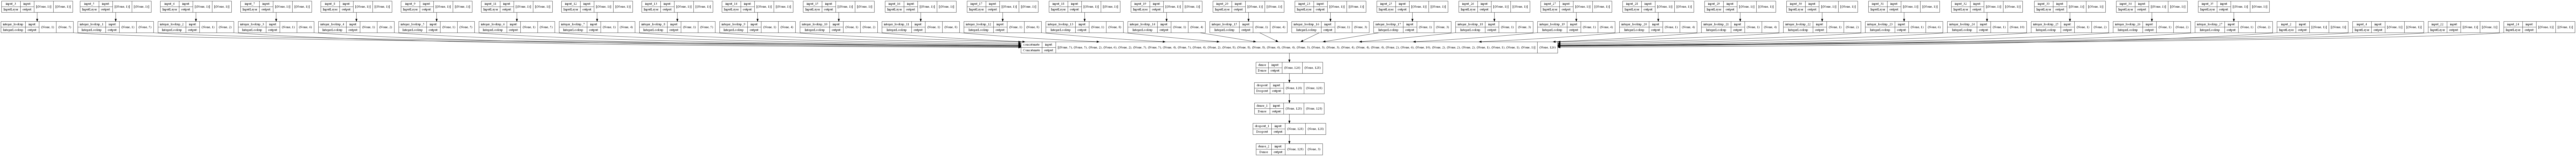

In [10]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, rankdir='TB', dpi=100)

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
NUM_EPOCHS = 300


checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=defs.GENERALIZING_MODEL,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_ds, epochs=NUM_EPOCHS, verbose=0, callbacks=callbacks_list, validation_data=val_ds)

INFO:tensorflow:Assets written to: C:\Users\Mikhail\PycharmProjects\Breast-Cancer\models\generalizing model\assets
INFO:tensorflow:Assets written to: C:\Users\Mikhail\PycharmProjects\Breast-Cancer\models\generalizing model\assets
INFO:tensorflow:Assets written to: C:\Users\Mikhail\PycharmProjects\Breast-Cancer\models\generalizing model\assets
INFO:tensorflow:Assets written to: C:\Users\Mikhail\PycharmProjects\Breast-Cancer\models\generalizing model\assets
INFO:tensorflow:Assets written to: C:\Users\Mikhail\PycharmProjects\Breast-Cancer\models\generalizing model\assets


In [13]:
model.save(defs.OVERFITTED_MODEL)

INFO:tensorflow:Assets written to: C:\Users\Mikhail\PycharmProjects\Breast-Cancer\models\overfitted model\assets


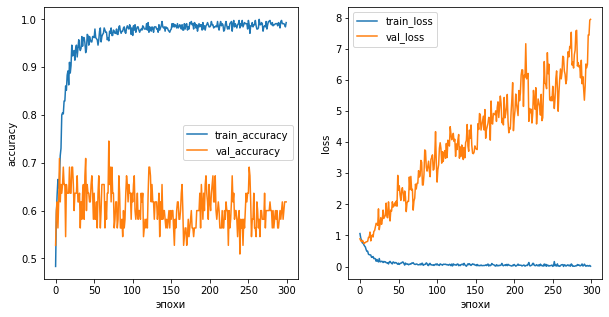

In [14]:
viz.plot_history(history)